In [7]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 

from sklearn.preprocessing import LabelEncoder


import numpy as np
import glob
import math
import seaborn as sns 
import matplotlib.pyplot as plt
import toad
import pickle
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr


from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, \
    precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve 

import warnings
warnings.filterwarnings('ignore')

In [8]:
pd.options.display.max_columns = None
df=pd.read_csv('loan_data_2007_2014.csv',low_memory=False)

In [9]:
def clean_data(df):
 
    
    ## cols to be dropped
    #'Unnamed: 0'> index to be used
    #'id', 'member_id'> not relevant in creating score card
    #funded_amnt, funded_amnt_inv same as loan amount. To be removed to avoid multicollinearity
    #grade to be dropped as sub-grade is a subset of grade
    #drop title as the purpose column will suffice
    #text attributes to be removed ['url']
    #policy code and application_type have only one unique value
    #last_pymnt_d can't be used during application
    #total_pymnt ,total_pymnt_inv are the same.total_pymnt_inv to be removed
    #emp_title
    
    df.drop(df[['Unnamed: 0','id','member_id','funded_amnt','funded_amnt_inv',
            'grade','url','application_type','title','policy_code','emp_title',
                'pymnt_plan','last_pymnt_d','last_pymnt_amnt','total_pymnt_inv','zip_code','addr_state']],
            axis=1,inplace=True)
    
     #Drop columns with  70% N/A of the data:
    df.dropna(axis='columns', thresh=0.7*len(df),inplace=True)
    
    df['emp_length'].replace({ '10+ years': 10, '< 1 year': 0, '1 year': 1,'2 years': 2,'3 years': 3,'4 years': 4,
    '5 years': 5,'6 years': 6,'7 years': 7,'8 years': 8,'9 years': 9},inplace=True)
    
    
    # Calculate mode of the column
    mode_value = df['emp_length'].mode()[0]

    # Replace missing values with mode
    df['emp_length'] = df['emp_length'].fillna(mode_value)
    
    # Replace all numerical values where NA with -9999
    df[df.select_dtypes(include=['int64', 'float64']).columns] = df.select_dtypes(include=['int64', 'float64']).fillna(-9999)
    
    
    return df

df=clean_data(df)

In [10]:
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,36 months,10.65,162.87,B2,10.0,RENT,24000.0,Verified,Dec-11,Fully Paid,credit_card,27.65,0.0,Jan-85,1.0,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5000.00,861.07,0.00,0.00,0.00,Jan-16,0.0,0.0,-9999.0,-9999.0,-9999.0
1,2500,60 months,15.27,59.83,C4,0.0,RENT,30000.0,Source Verified,Dec-11,Charged Off,car,1.00,0.0,Apr-99,5.0,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,456.46,435.17,0.00,117.08,1.11,Sep-13,0.0,0.0,-9999.0,-9999.0,-9999.0
2,2400,36 months,15.96,84.33,C5,10.0,RENT,12252.0,Not Verified,Dec-11,Fully Paid,small_business,8.72,0.0,Nov-01,2.0,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,2400.00,603.65,0.00,0.00,0.00,Jan-16,0.0,0.0,-9999.0,-9999.0,-9999.0
3,10000,36 months,13.49,339.31,C1,10.0,RENT,49200.0,Source Verified,Dec-11,Fully Paid,other,20.00,0.0,Feb-96,1.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,10000.00,2209.33,16.97,0.00,0.00,Jan-15,0.0,0.0,-9999.0,-9999.0,-9999.0
4,3000,60 months,12.69,67.79,B5,1.0,RENT,80000.0,Source Verified,Dec-11,Current,other,17.94,0.0,Jan-96,0.0,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,2233.10,1009.07,0.00,0.00,0.00,Jan-16,0.0,0.0,-9999.0,-9999.0,-9999.0


In [11]:
def feat_eng(df):
    # credit history tenure
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')
    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')
    df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%y')
    
    

    df['credit_history_tenure_years']=(df['issue_d']-df['earliest_cr_line']).dt.days / 365.25
    df['credit_history_tenure_months'] = (df['issue_d'].dt.to_period('M') - df['earliest_cr_line'].dt.to_period('M'))
    df['credit_history_tenure_months'] = df['credit_history_tenure_months'].apply(lambda x: x.n if x is not pd.NaT else 0)


    df['earliest_cr_line_month'] = df['earliest_cr_line'].dt.month

    # Months between issue
    df['credit_pull_months'] = (df['issue_d'].dt.to_period('M') - df['last_credit_pull_d'].dt.to_period('M'))
    df['credit_pull_months'] = df['credit_pull_months'].apply(lambda x: x.n if x is not pd.NaT else 0)
    
    
    df['loan_to_income_ratio'] = df['loan_amnt'] / df['annual_inc']
    

    df.drop(['earliest_cr_line','last_credit_pull_d','last_credit_pull_d'],axis=1,inplace=True)
    return df

df=feat_eng(df)

In [12]:
def good_bad(df):
    
    # assign 1 to bad loans(default) and 0 to good loans
    
    #bad loans
    condition=np.isin(df['loan_status'],['Charged Off','Late (31-120 days)','Late (16-30 days)','Default','Does not meet the credit policy. Status:Charged Off'])
    replace=['1']
    df['loan_status']=np.where(condition,replace,df['loan_status'])
    
    #good loans
    condition2=np.isin(df['loan_status'],['Fully Paid','Does not meet the credit policy. Status:Fully Paid'],)
    replace=['0']
    df['loan_status']=np.where(condition2,replace,df['loan_status'])
    
    ## I will drop status In Grace Period and Current because we are not sure if they will repay the loans or not
    values_to_drop = ['In Grace Period', 'Current']
    df = df[~df['loan_status'].isin(values_to_drop)]
    
    return df


df=good_bad(df)

In [13]:
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,credit_history_tenure_years,credit_history_tenure_months,earliest_cr_line_month,credit_pull_months,loan_to_income_ratio
0,5000,36 months,10.65,162.87,B2,10.0,RENT,24000.0,Verified,2011-12-01,0,credit_card,27.65,0.0,1.0,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5000.00,861.07,0.00,0.00,0.00,0.0,0.0,-9999.0,-9999.0,-9999.0,26.913073,323,1.0,-49,0.208333
1,2500,60 months,15.27,59.83,C4,0.0,RENT,30000.0,Source Verified,2011-12-01,1,car,1.00,0.0,5.0,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,456.46,435.17,0.00,117.08,1.11,0.0,0.0,-9999.0,-9999.0,-9999.0,12.668036,152,4.0,-21,0.083333
2,2400,36 months,15.96,84.33,C5,10.0,RENT,12252.0,Not Verified,2011-12-01,0,small_business,8.72,0.0,2.0,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,2400.00,603.65,0.00,0.00,0.00,0.0,0.0,-9999.0,-9999.0,-9999.0,10.080767,121,11.0,-49,0.195886
3,10000,36 months,13.49,339.31,C1,10.0,RENT,49200.0,Source Verified,2011-12-01,0,other,20.00,0.0,1.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,10000.00,2209.33,16.97,0.00,0.00,0.0,0.0,-9999.0,-9999.0,-9999.0,15.830253,190,2.0,-37,0.203252
5,5000,36 months,7.90,156.46,A4,3.0,RENT,36000.0,Source Verified,2011-12-01,0,wedding,11.20,0.0,3.0,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.377753,5000.00,631.38,0.00,0.00,0.00,0.0,0.0,-9999.0,-9999.0,-9999.0,7.080082,85,11.0,-45,0.138889


In [9]:
df['loan_status'].value_counts()

loan_status
1    186727
0     52186
Name: count, dtype: int64

In [15]:
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')
df['loan_status'] = pd.to_numeric(df['loan_status'])

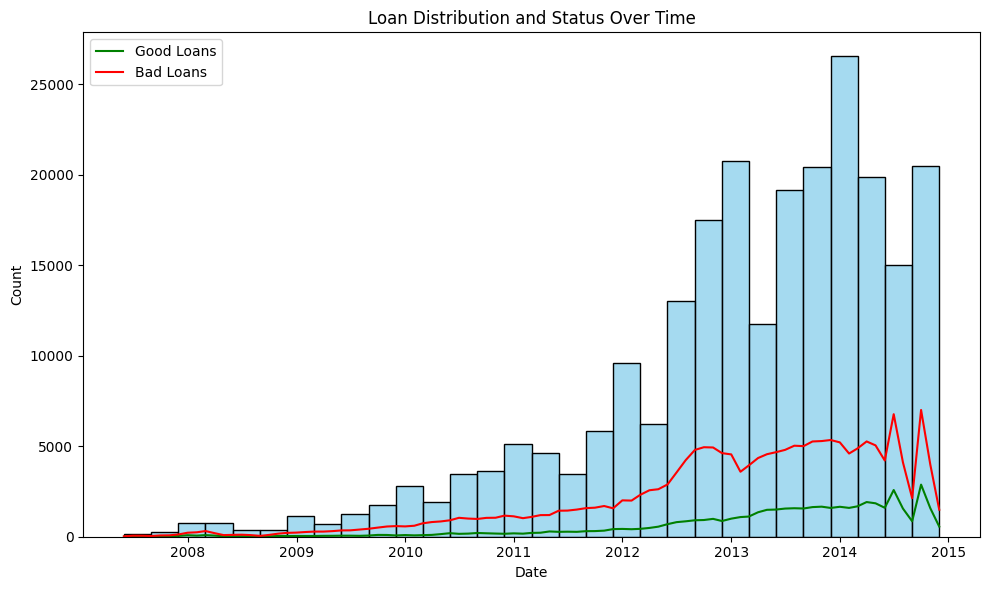

In [17]:
# Plotting
plt.figure(figsize=(10, 6))

# Histogram with loan distribution over time
sns.histplot(data=df, x='issue_d', bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Date')
plt.ylabel('Count', color='skyblue')
plt.title('Loan Distribution and Status Over Time')

# Line plot for good loans
good_loans = df[df['loan_status'] == 1].groupby('issue_d').size().reset_index(name='Count')
sns.lineplot(data=good_loans, x='issue_d', y='Count', color='green', label='Good Loans')

# Line plot for bad loans
bad_loans = df[df['loan_status'] == 0].groupby('issue_d').size().reset_index(name='Count')
sns.lineplot(data=bad_loans, x='issue_d', y='Count', color='red', label='Bad Loans')

 
#plt.axvline(pd.to_datetime('2013-07-01'), color='gray', linestyle='--', linewidth=1)


plt.ylabel('Count', color='black')
plt.legend()
plt.tight_layout()
plt.show()

# Filter issue date to determine sample window

In [18]:
train_start_date = '2010-01-01'
train_end_date = '2013-06-30'
test_start_date = '2013-07-01'
test_end_date = '2013-12-31'

In [20]:
# Split the data into (training data) and (test data)
train = df[(df['issue_d'] >= train_start_date) & (df['issue_d'] <= train_end_date)]
test = df[(df['issue_d'] >= test_start_date) & (df['issue_d'] <= test_end_date)]


print("(Training Data) Size:", len(train))
print("(Test Data) Size:", len(test))

(Training Data) Size: 115312
(Test Data) Size: 40312


In [21]:
train.drop(['issue_d'],inplace=True,axis=1)

In [22]:
X_train=train.drop('loan_status',axis=1)
y_train=train['loan_status']
X_test=test.drop('loan_status',axis=1)
y_test=test['loan_status']